In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from nilearn.image import math_img, new_img_like
from nilearn.plotting import plot_roi

from survey_medley_code.config_loader import load_config

In [2]:
cfg = load_config()

In [3]:
outdir = cfg.output_root / 'within_subject_question_estimates'

omnibus_pmap_file = outdir / 'group_f_test/glm_tfce_1minuspvalue_fstat_omnibusf.nii.gz'
omnibus_fmap_file = outdir / 'group_f_test/glm_fstat_omnibusf.nii.gz'
mask_path = (
    cfg.output_root / 'assess_subject_bold_dropout/group_mask_intersection_30pct.nii.gz'
)
paired_outdir = outdir / 'all_paired_t_tests'

In [4]:
questionnaire_names = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']

question_tmaps = {}

qa = 'brief'
for qb in ['future_time', 'grit', 'impulsive_venture', 'upps']:
    pairing_name = f'{qa}_minus_{qb}'
    paired_t_loop = (
        paired_outdir / f'paired_test_{pairing_name}/uncorrected_tstat1.nii.gz'
    )
    question_tmaps[pairing_name] = paired_t_loop

# Try to compute ranks (questionnaire-based activation ranks) from paired differences

In [5]:
# I need to smooth the data to see if that makes the results less noisy.


In [6]:
import itertools

from scipy.ndimage import uniform_filter

questionnaires = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']
others = ['future_time', 'grit', 'impulsive_venture', 'upps']

# --- Load brain mask ---
mask_img = nib.load(mask_path)
mask = mask_img.get_fdata().astype(bool)

# --- Load t-maps, mask, and smooth ---
t_arrays = []
for qb in others:
    fname = question_tmaps[f'brief_minus_{qb}']
    t_arr = nib.load(str(fname)).get_fdata()

    # Mask non-brain voxels
    t_arr_masked = np.where(mask, t_arr, 0)

    # Smooth with uniform 3x3x3 neighborhood
    t_arr_smooth = uniform_filter(t_arr_masked, size=3)

    t_arrays.append(t_arr_smooth)

# Stack smoothed maps
t_maps = np.stack(t_arrays, axis=-1)  # shape (X,Y,Z,4)

# Flatten voxel dimension
orig_shape = t_maps.shape[:-1]
t = t_maps.reshape(-1, 4)  # (N_voxels, 4)

# --- Step 1: order the other questionnaires ---
rank_others = np.argsort(-t, axis=1)  # largest t-value first

# --- Step 2: determine brief rank ---
brief_rank = np.sum(t < 0, axis=1)  # # of negative differences → position of 'brief'

# --- Step 3: build full ranking per voxel ---
global_other_index = np.array([questionnaires.index(q) for q in others])  # [1,2,3,4]
N = t.shape[0]
full_ranking = np.zeros((N, 5), dtype=int)

for i in range(N):
    sorted_others = global_other_index[rank_others[i]]
    br = brief_rank[i]
    full_order = np.insert(sorted_others, br, 0)
    full_ranking[i] = full_order

# --- Step 4: assign integer ID for each permutation ---
all_perms = list(itertools.permutations(range(5)))
perm_index = {perm: idx for idx, perm in enumerate(all_perms)}

rank_ids = np.array([perm_index[tuple(r)] for r in full_ranking])
rank_ids = rank_ids.reshape(orig_shape)

# --- Optional: zero out voxels outside mask in final rank_ids ---
rank_ids = np.where(mask, rank_ids, 0)

In [7]:
# import itertools

# questionnaires = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']
# others = ['future_time', 'grit', 'impulsive_venture', 'upps']

# # ---- Load maps into a 4D array (X,Y,Z,4) ----
# t_arrays = []
# for qb in others:
#     fname = question_tmaps[f'brief_minus_{qb}']
#     t_arrays.append(nib.load(str(fname)).get_fdata())

# t_maps = np.stack(t_arrays, axis=-1)  # shape (X,Y,Z,4)

# # Flatten voxel dimension if desired
# orig_shape = t_maps.shape[:-1]
# t = t_maps.reshape(-1, 4)  # (N_voxels, 4)

# # ---- Step 1: order the other questionnaires ----
# # argsort(-t) gives ranking of others from smallest activation to largest activation
# rank_others = np.argsort(-t, axis=1)  # (N_voxels, 4)

# # ---- Step 2: determine brief rank ----
# # brief_rank = number of negatives (i.e., brief worse than that many questionnaires)
# brief_rank = np.sum(t < 0, axis=1)  # (N_voxels,)

# # ---- Step 3: build full ranking per voxel ----
# # Convert local 0–3 index in "others" to global 1–4 (since 0=brief)
# global_other_index = np.array([questionnaires.index(q) for q in others])  # [1,2,3,4]

# # For each voxel, we will create a (5,) ranking vector
# N = t.shape[0]
# full_ranking = np.zeros((N, 5), dtype=int)

# for i in range(N):
#     # others sorted by original activation
#     sorted_others = global_other_index[rank_others[i]]

#     # insert brief (index 0) at correct position
#     br = brief_rank[i]
#     full_order = np.insert(sorted_others, br, 0)

#     full_ranking[i] = full_order

# # ---- Step 4 (optional): assign integer ID for each of 120 permutations ----
# all_perms = list(itertools.permutations(range(5)))
# perm_index = {perm: idx for idx, perm in enumerate(all_perms)}

# rank_ids = np.array([perm_index[tuple(r)] for r in full_ranking])
# rank_ids = rank_ids.reshape(orig_shape)


In [8]:
flat_rank_ids = rank_ids.ravel()

# Count unique rankings and their occurrences
unique_ids, counts = np.unique(flat_rank_ids, return_counts=True)

print(f'Total unique rankings observed: {len(unique_ids)}')

# Optional: show top rankings by voxel count
for uid, count in zip(unique_ids, counts):
    ranking = all_perms[uid]  # get actual permutation
    ranking_labels = [questionnaires[i] for i in ranking]
    print(f'Ranking {ranking_labels}: {count} voxels')

Total unique rankings observed: 120
Ranking ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']: 653435 voxels
Ranking ['brief', 'future_time', 'grit', 'upps', 'impulsive_venture']: 403 voxels
Ranking ['brief', 'future_time', 'impulsive_venture', 'grit', 'upps']: 143 voxels
Ranking ['brief', 'future_time', 'impulsive_venture', 'upps', 'grit']: 111 voxels
Ranking ['brief', 'future_time', 'upps', 'grit', 'impulsive_venture']: 180 voxels
Ranking ['brief', 'future_time', 'upps', 'impulsive_venture', 'grit']: 78 voxels
Ranking ['brief', 'grit', 'future_time', 'impulsive_venture', 'upps']: 906 voxels
Ranking ['brief', 'grit', 'future_time', 'upps', 'impulsive_venture']: 768 voxels
Ranking ['brief', 'grit', 'impulsive_venture', 'future_time', 'upps']: 795 voxels
Ranking ['brief', 'grit', 'impulsive_venture', 'upps', 'future_time']: 789 voxels
Ranking ['brief', 'grit', 'upps', 'future_time', 'impulsive_venture']: 817 voxels
Ranking ['brief', 'grit', 'upps', 'impulsive_venture', 'futu

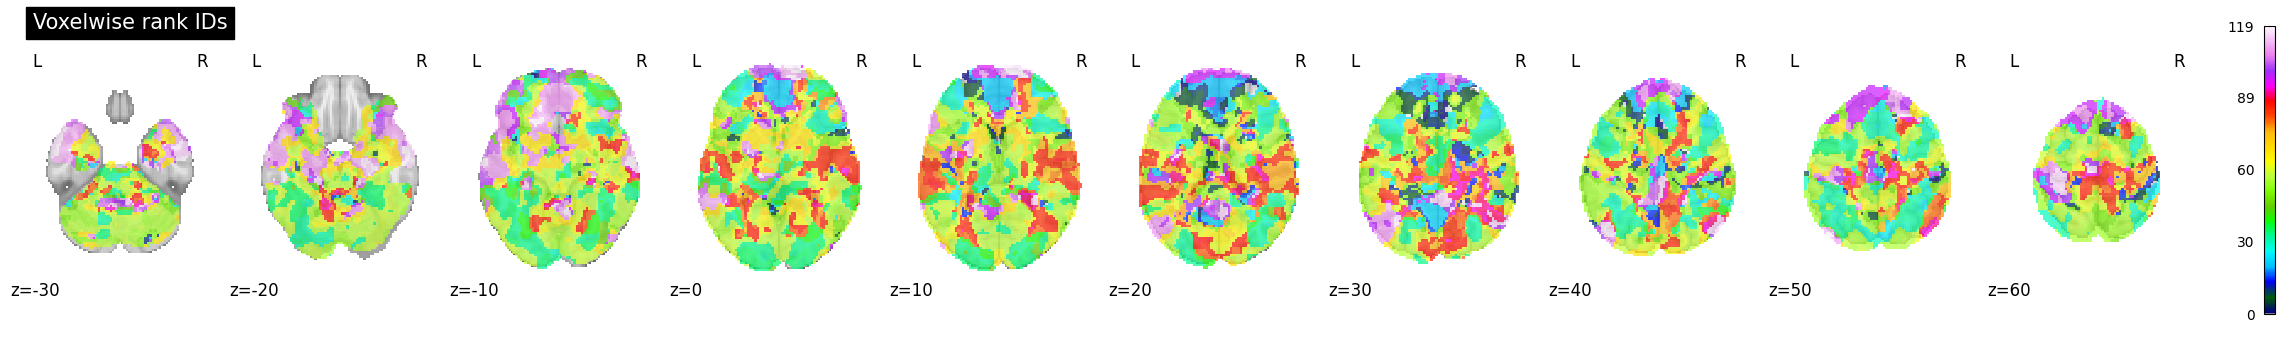

In [9]:
# Use one of your reference images for affine/shape info
ref_img = nib.load(str(question_tmaps['brief_minus_future_time']))

# Create a NIfTI image for the rank IDs
rank_img = new_img_like(ref_img, rank_ids.astype(np.int32))

z_slices = list(range(-30, 61, 10))


# Plot using nilearn
plot_roi(
    rank_img,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    title='Voxelwise rank IDs',
)
plt.show()

Mask with signifiance mask and see if this simplifies the results.

In [10]:
from nilearn.image import new_img_like

# masked rank image: only keep voxels where omnibus_pmap > 0.95
masked_rank_img = math_img(
    'rank_img * (omnibus > 0.95)', rank_img=rank_img, omnibus=omnibus_pmap_file
)

masked_data = masked_rank_img.get_fdata().astype(int)
unique_vals, num_unique = np.unique(masked_data, return_counts=True)
unique_vals = unique_vals[unique_vals != 0]  # ignore zero
print(num_unique)
print(np.sum(num_unique > 800))

[749645     93      6     48      4    151    105     63    106    182
    132     23     16     46     70     32     57    128     31    944
    979    120    539    926    427    326    146      2   4059   1965
   2778   4652   1988   3478    224      1    253    852      8     35
     44      2    164    484      2     22    803    884    654    422
    891    165   5238   4624   3657   3626   4251   3046    905    394
    899    716    137     58   1286    261   1207    653    258     94
    347     22    701    775     40    398    366     31    599    633
     35      9   1372   1220    986    679    244      9    118    228
     60      3    129      8    451      9   2279    729     42    407
    264     50    335    290    141     10   1649   1036   1052    517
    509    104    196    501    218     11    396     10]
31


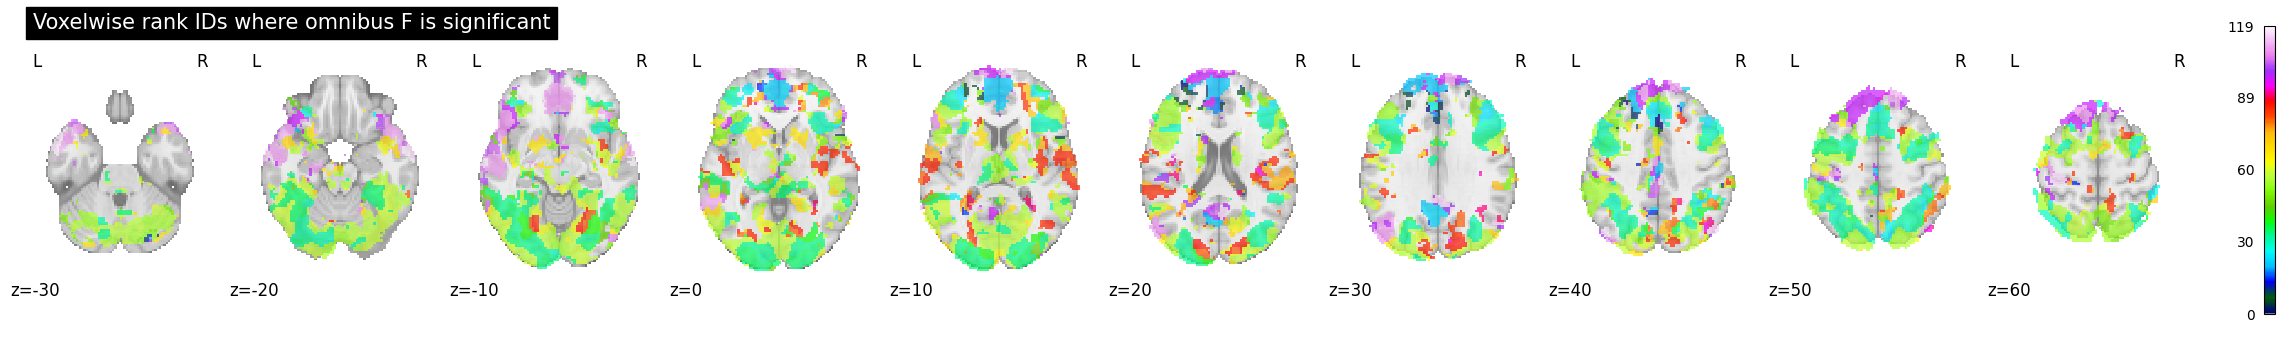

In [11]:
plot_roi(
    masked_rank_img,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    title='Voxelwise rank IDs where omnibus F is significant',
)

## Plot each unique ranking with > 800 voxels in the F-stat mask

The rankings are listed from biggest to smallest.  Note that statistical significance is not reflected in these rankings.

Integer 20: 944 voxels -> brief, upps, grit, future_time, impulsive_venture


/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/survey_medley_code/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2896: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


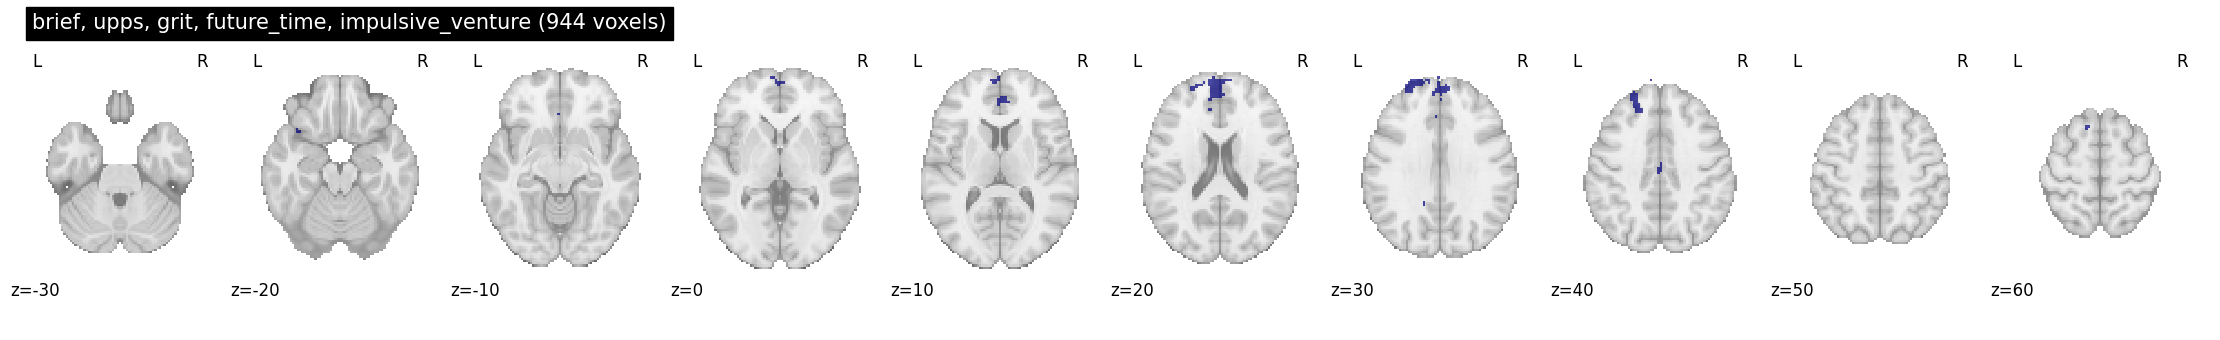

Integer 21: 979 voxels -> brief, upps, grit, impulsive_venture, future_time


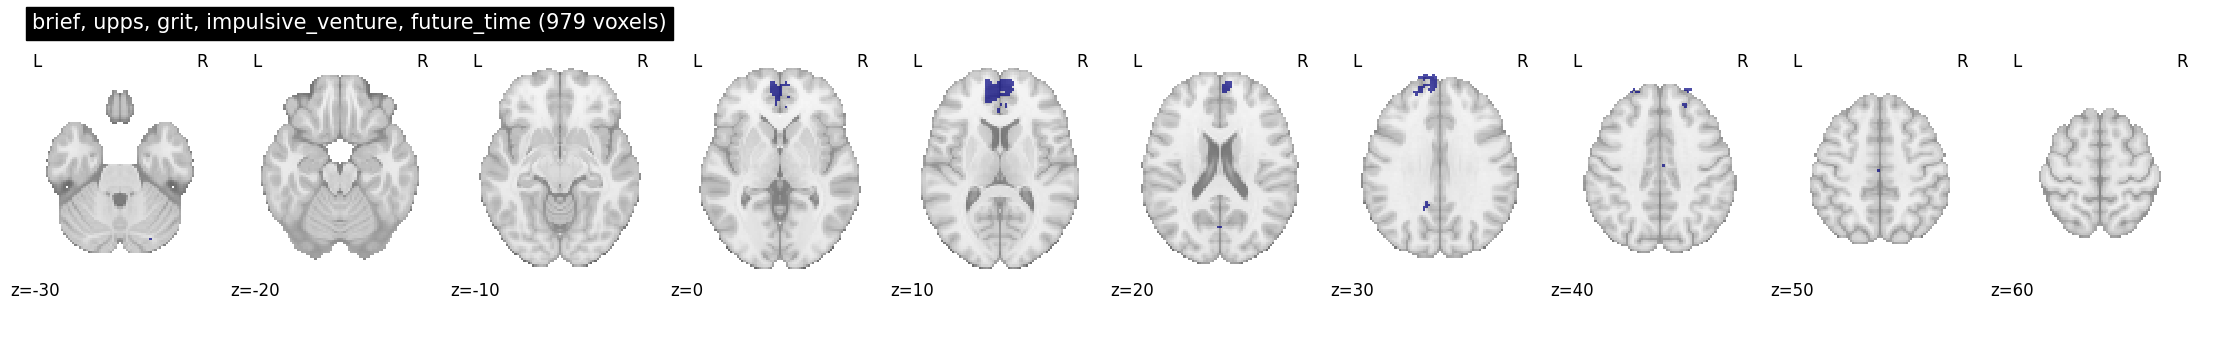

Integer 24: 926 voxels -> future_time, brief, grit, impulsive_venture, upps


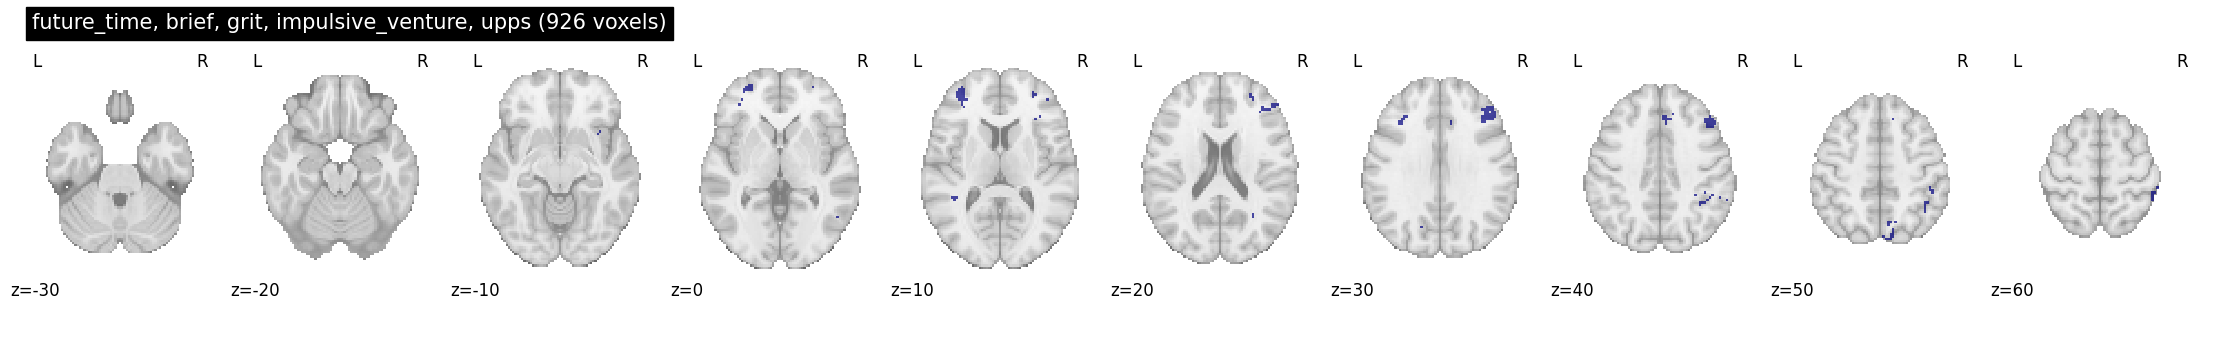

Integer 30: 4059 voxels -> future_time, grit, brief, impulsive_venture, upps


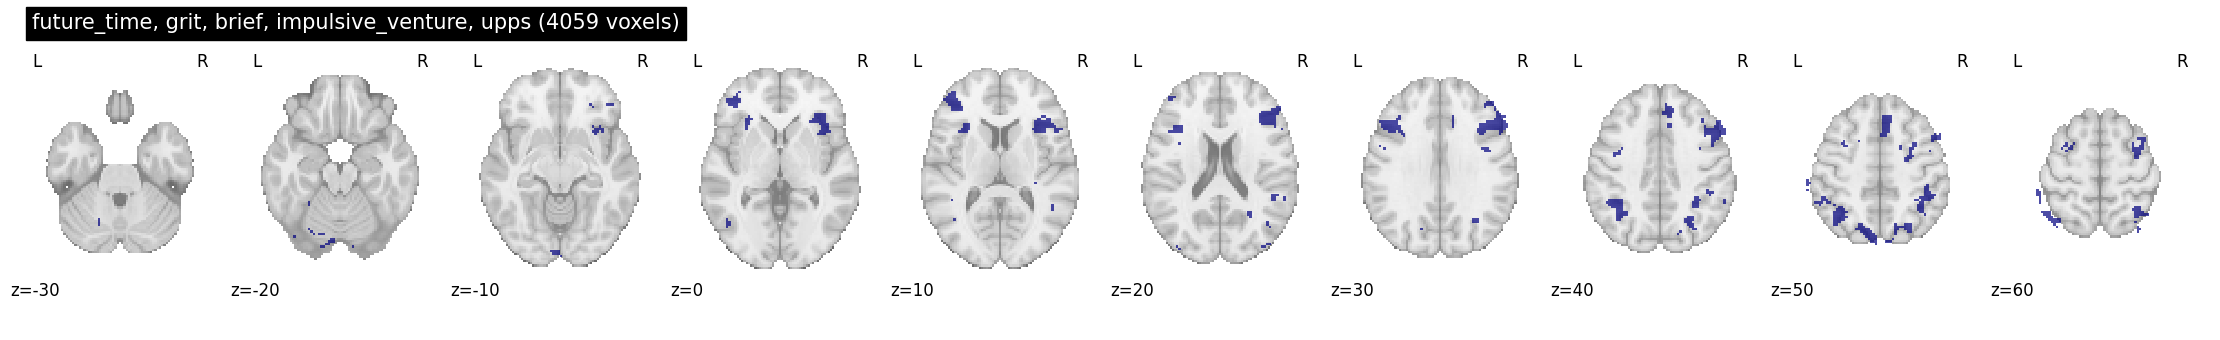

Integer 31: 1965 voxels -> future_time, grit, brief, upps, impulsive_venture


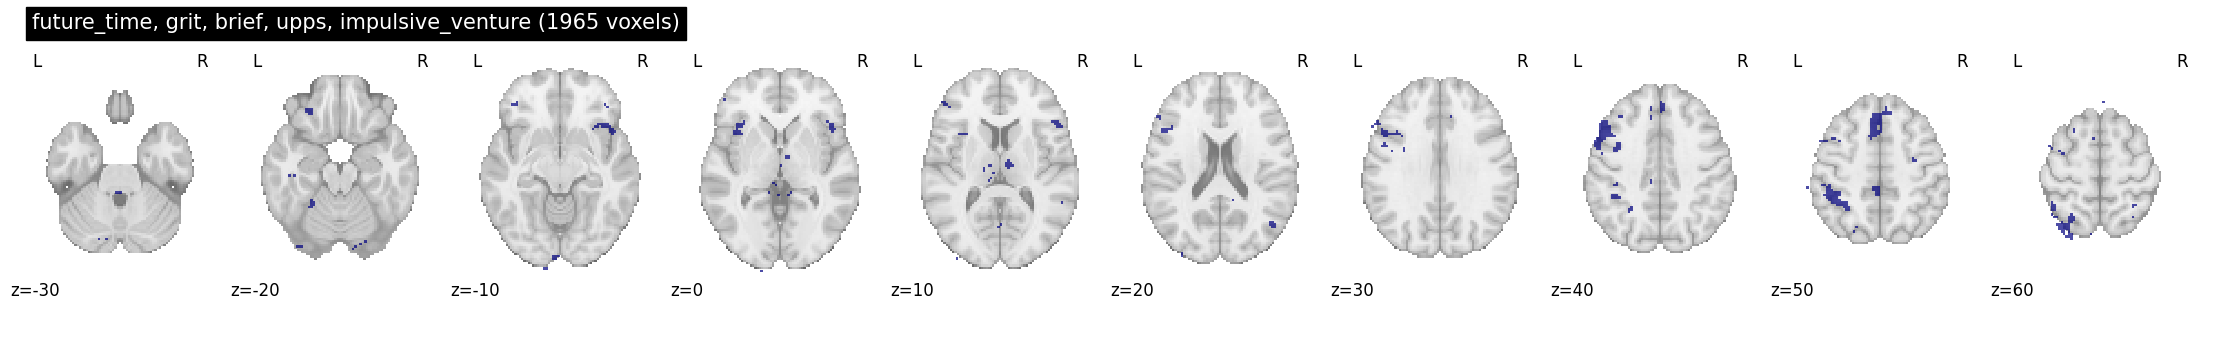

Integer 32: 2778 voxels -> future_time, grit, impulsive_venture, brief, upps


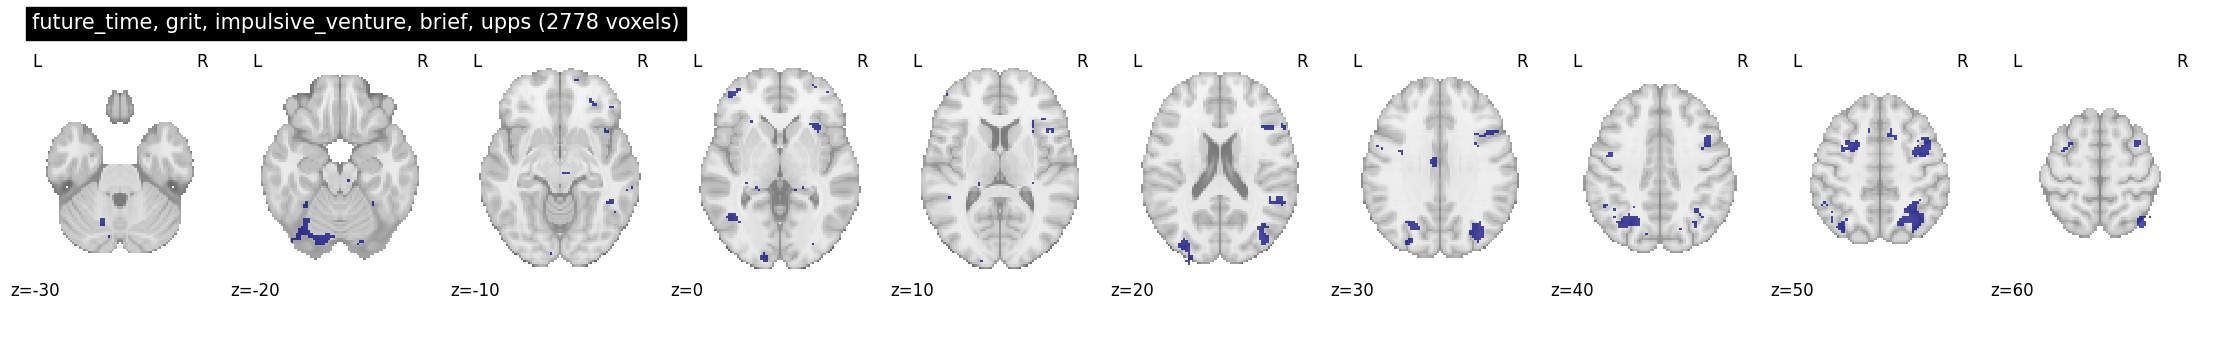

Integer 33: 4652 voxels -> future_time, grit, impulsive_venture, upps, brief


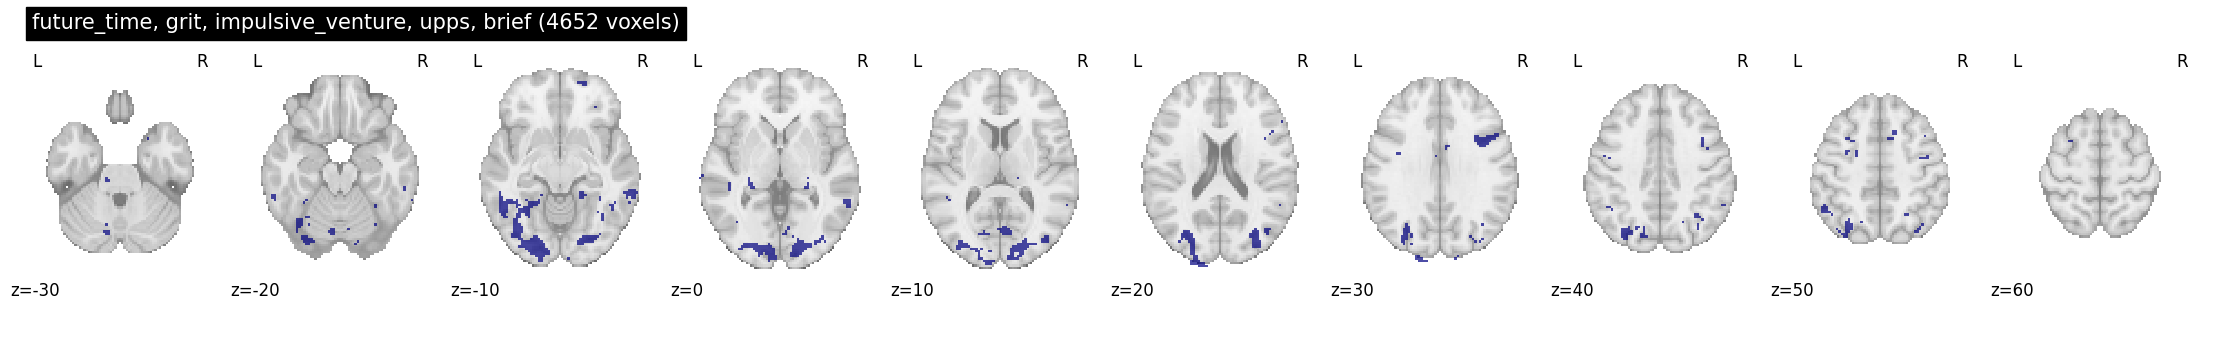

Integer 34: 1988 voxels -> future_time, grit, upps, brief, impulsive_venture


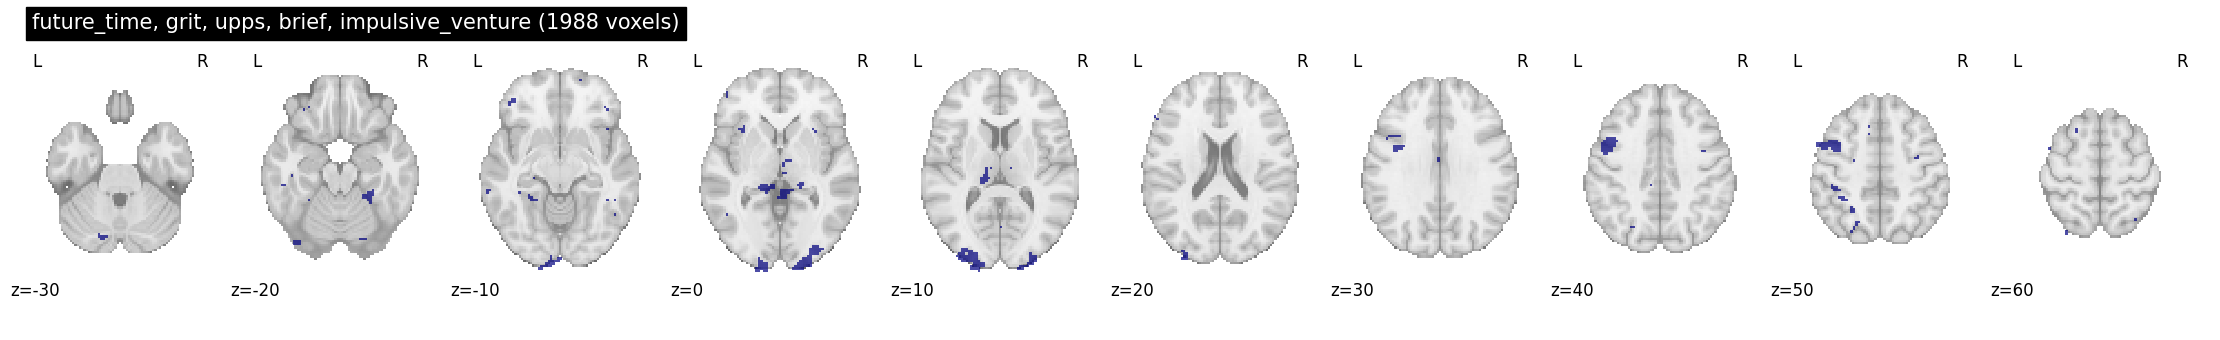

Integer 35: 3478 voxels -> future_time, grit, upps, impulsive_venture, brief


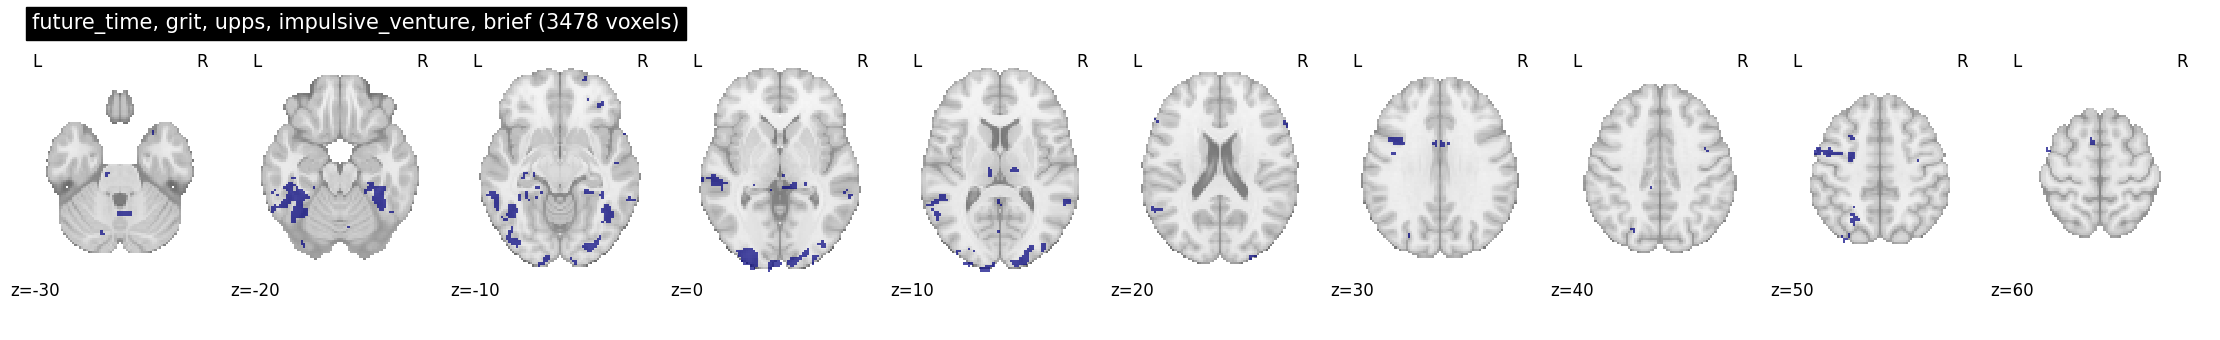

Integer 39: 852 voxels -> future_time, impulsive_venture, grit, upps, brief


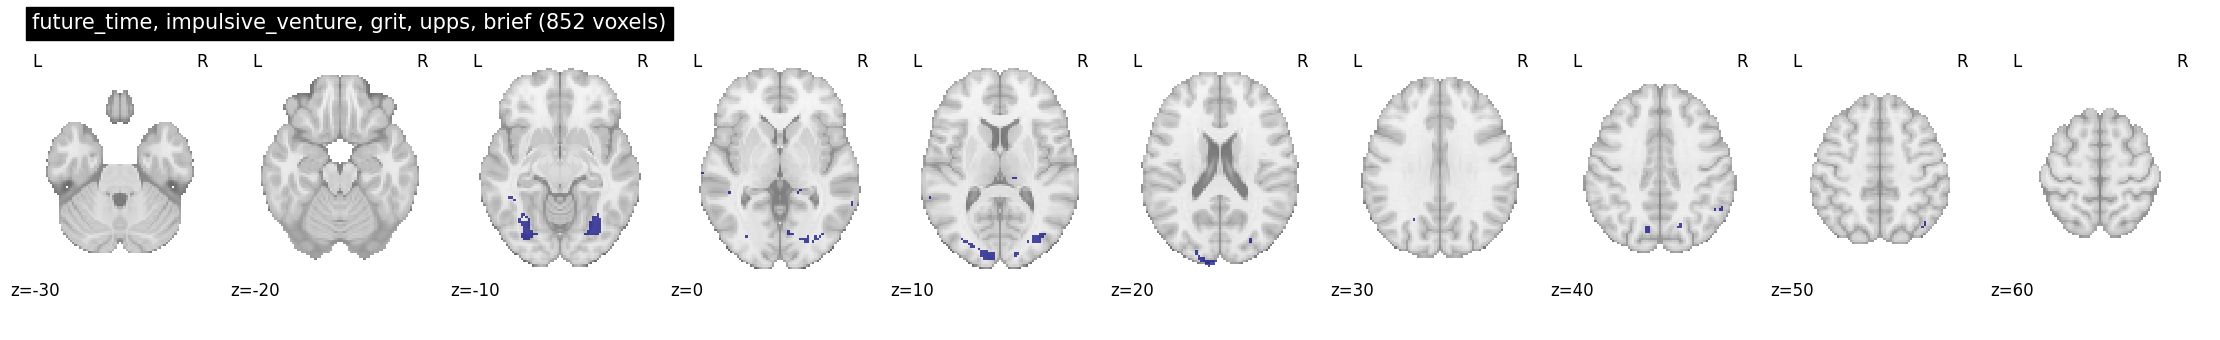

Integer 48: 803 voxels -> grit, brief, future_time, impulsive_venture, upps


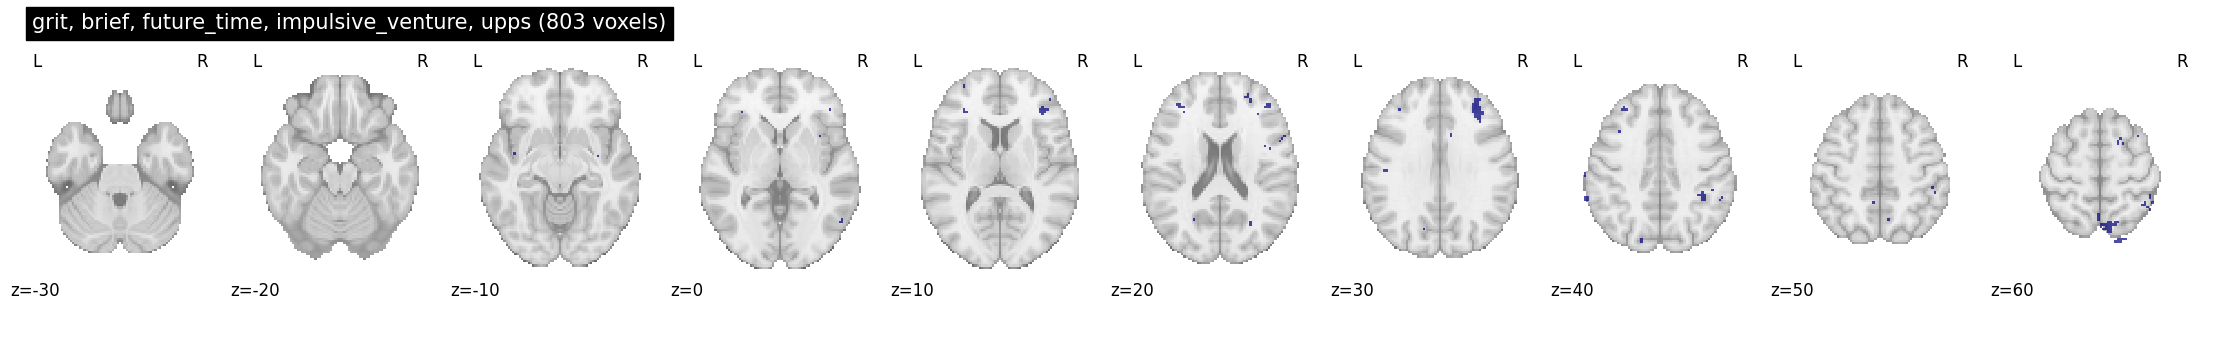

Integer 49: 884 voxels -> grit, brief, future_time, upps, impulsive_venture


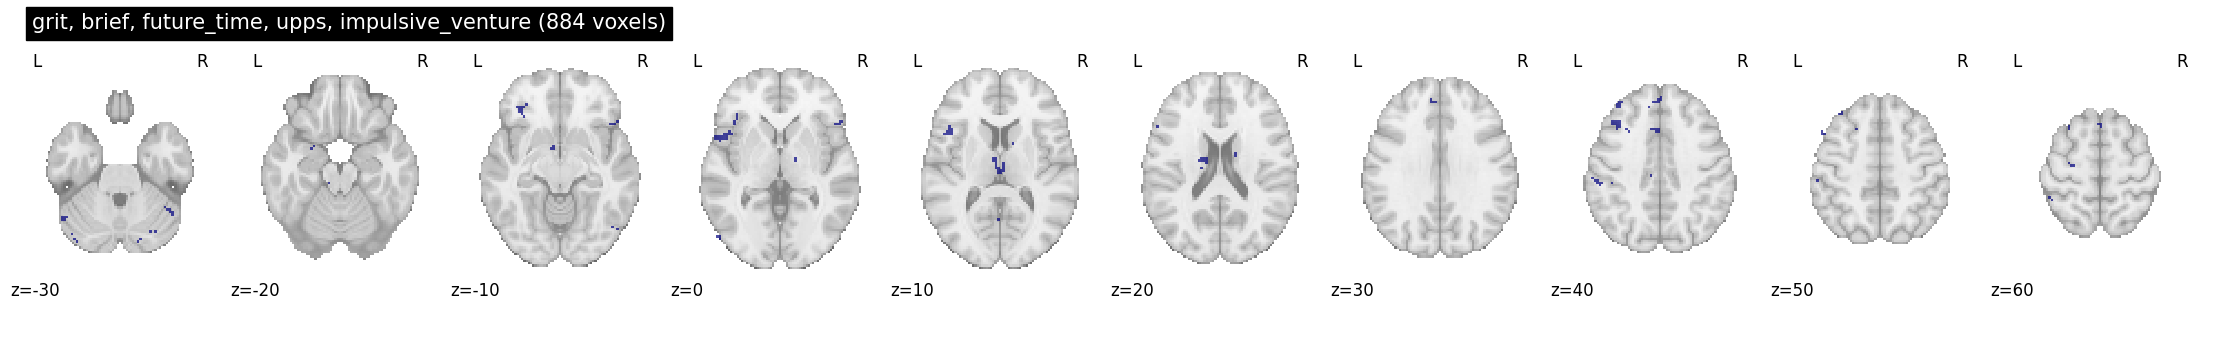

Integer 52: 891 voxels -> grit, brief, upps, future_time, impulsive_venture


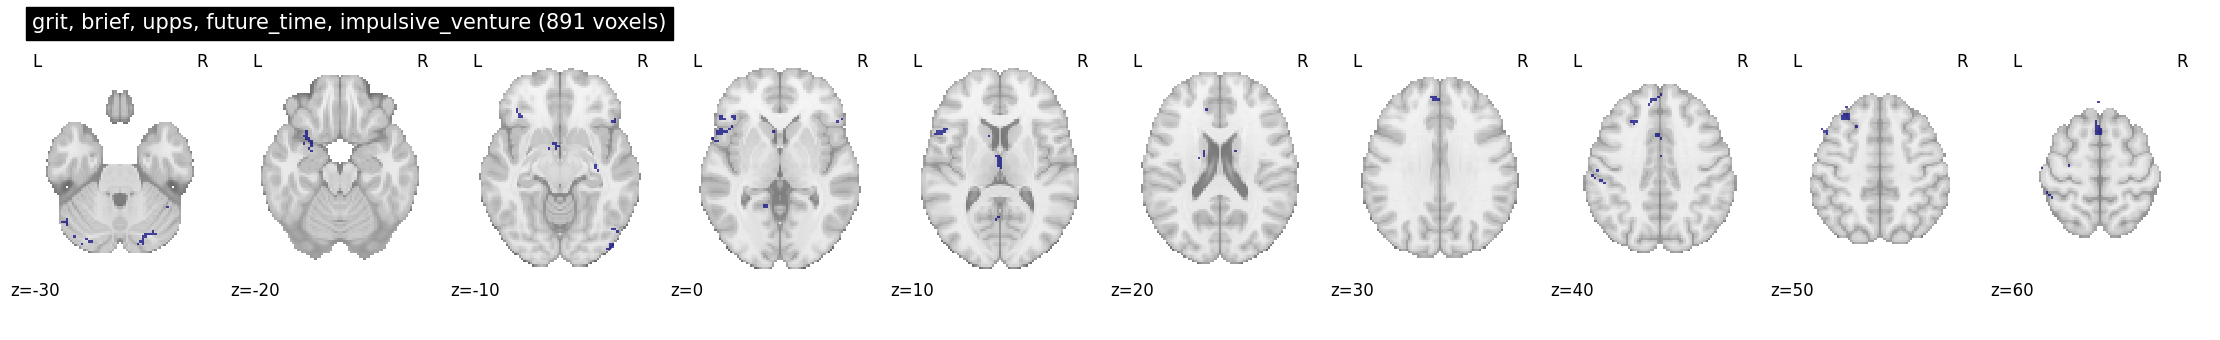

Integer 54: 5238 voxels -> grit, future_time, brief, impulsive_venture, upps


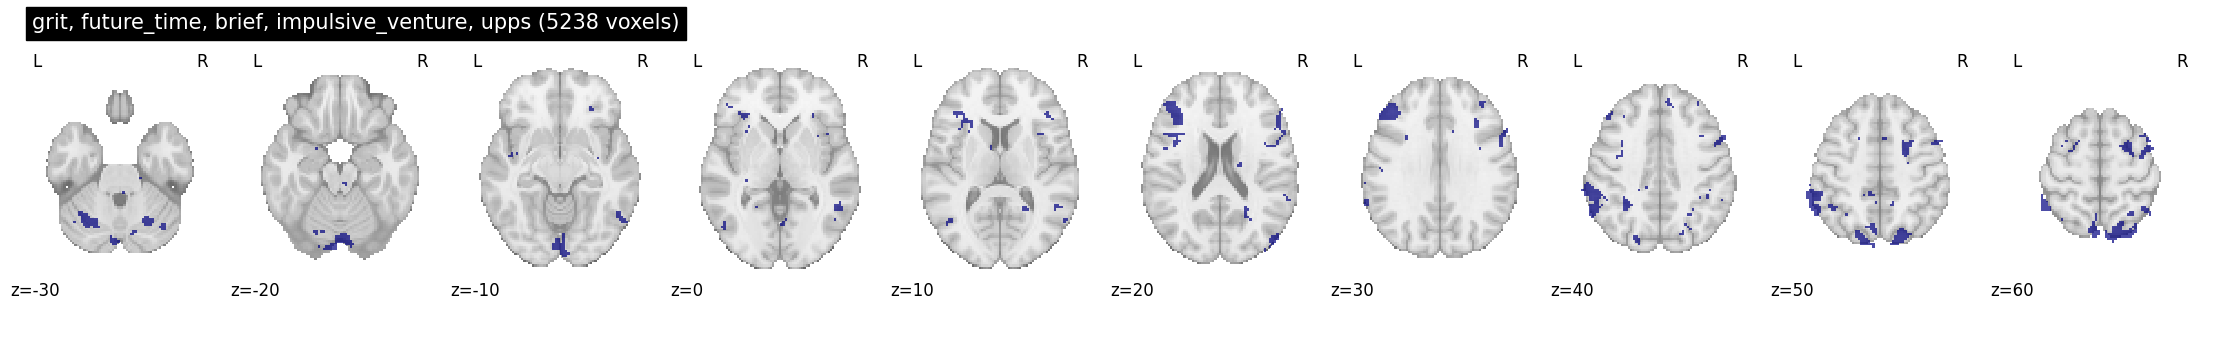

Integer 55: 4624 voxels -> grit, future_time, brief, upps, impulsive_venture


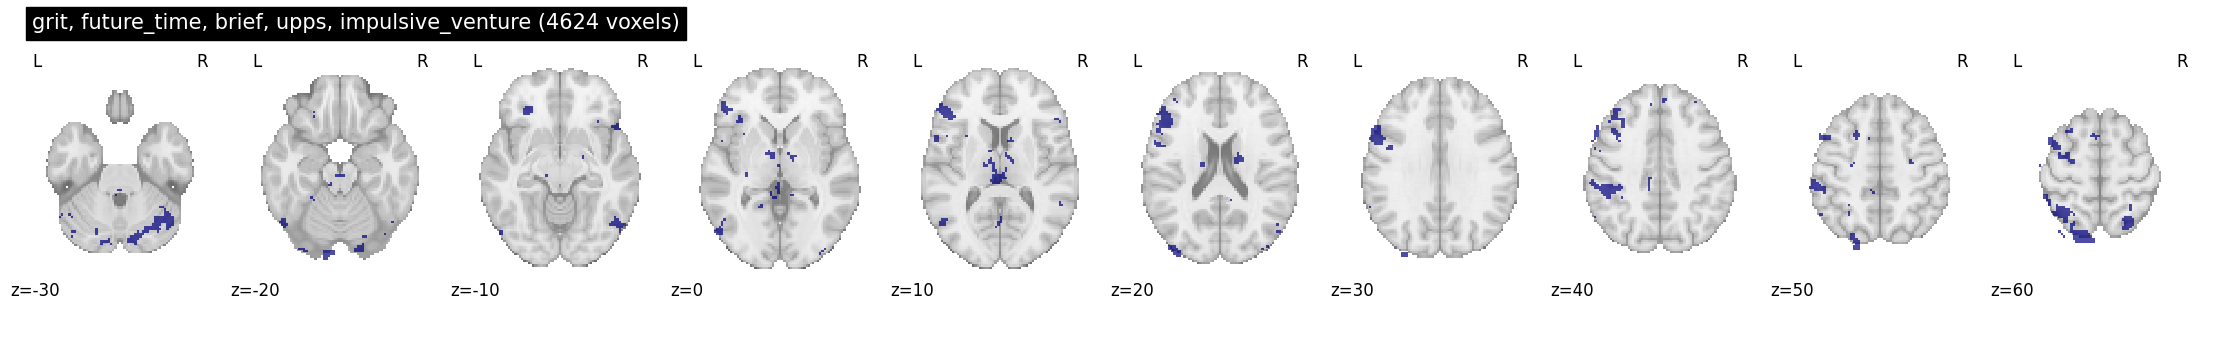

Integer 56: 3657 voxels -> grit, future_time, impulsive_venture, brief, upps


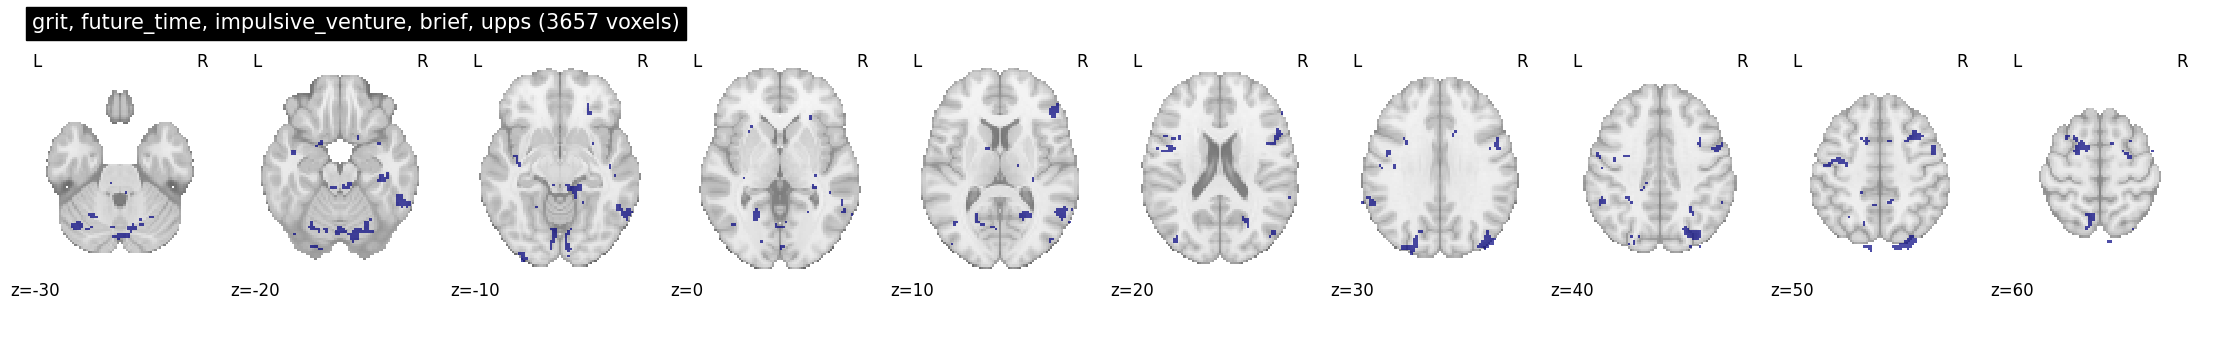

Integer 57: 3626 voxels -> grit, future_time, impulsive_venture, upps, brief


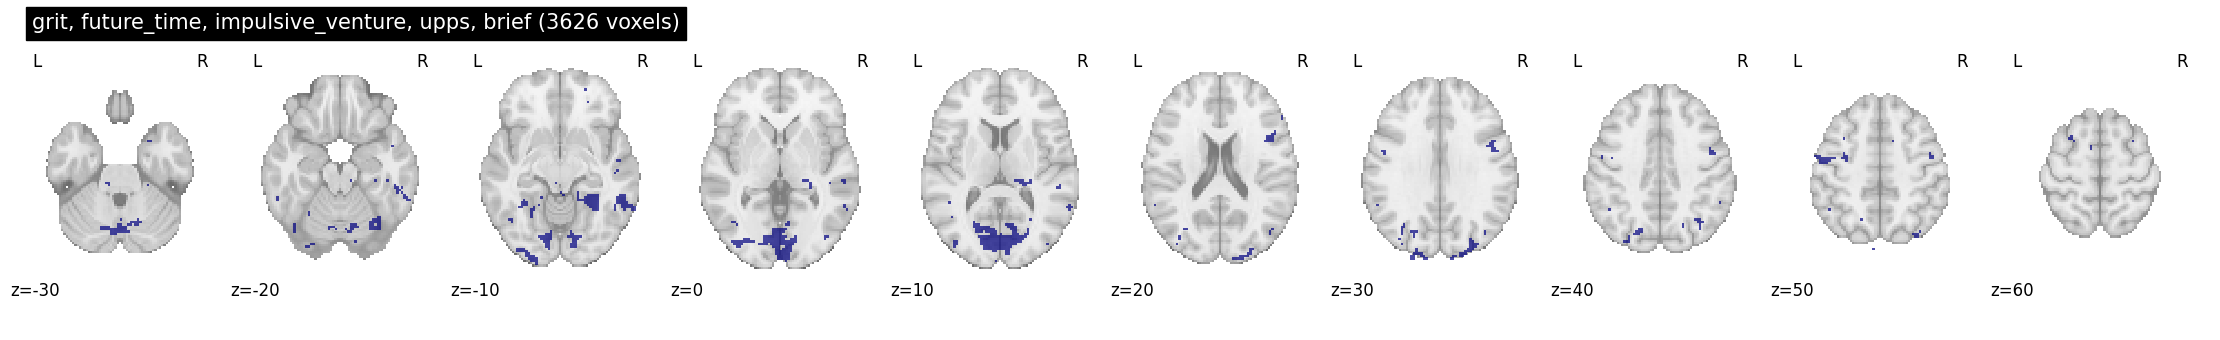

Integer 58: 4251 voxels -> grit, future_time, upps, brief, impulsive_venture


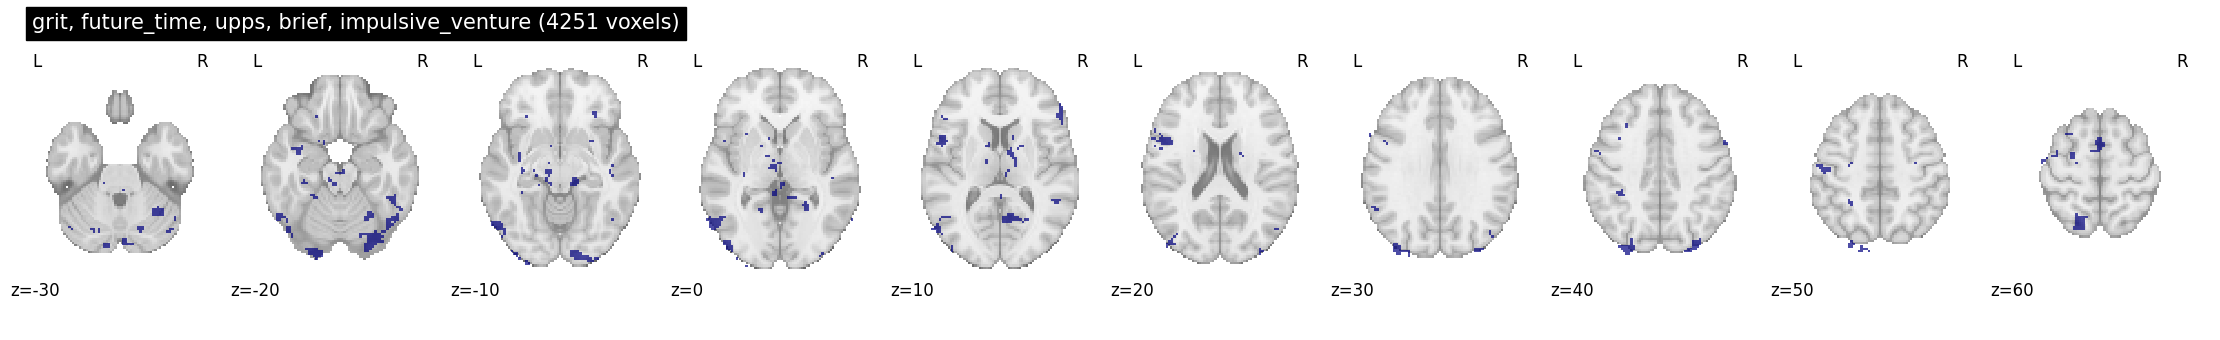

Integer 59: 3046 voxels -> grit, future_time, upps, impulsive_venture, brief


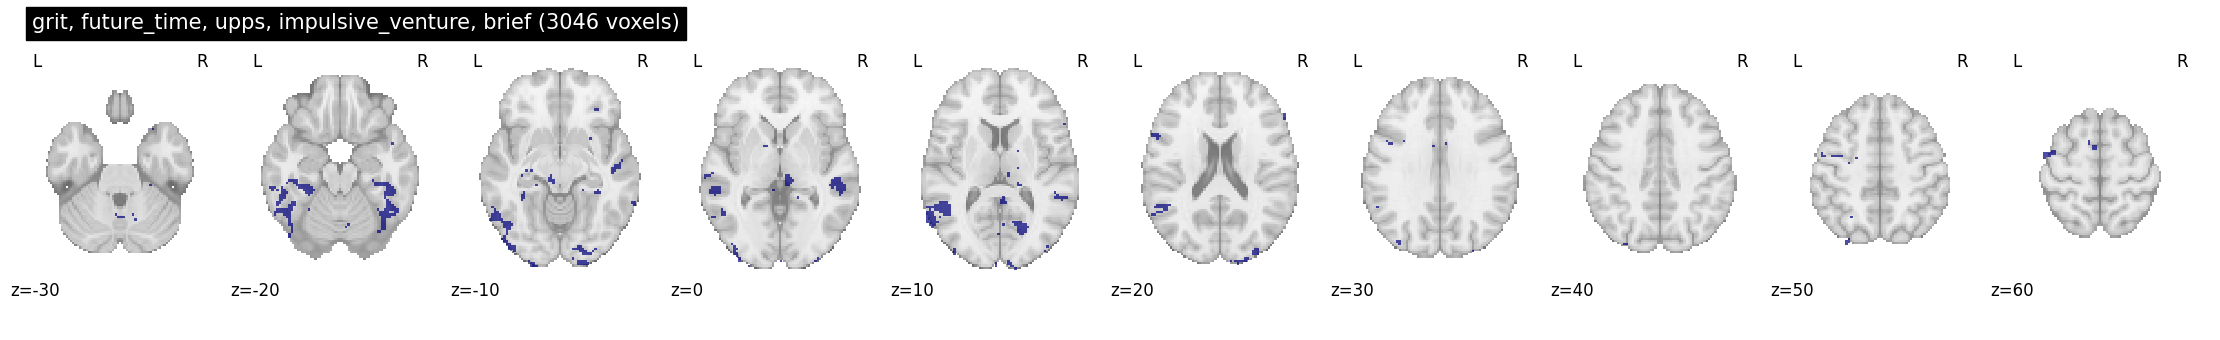

Integer 60: 905 voxels -> grit, impulsive_venture, brief, future_time, upps


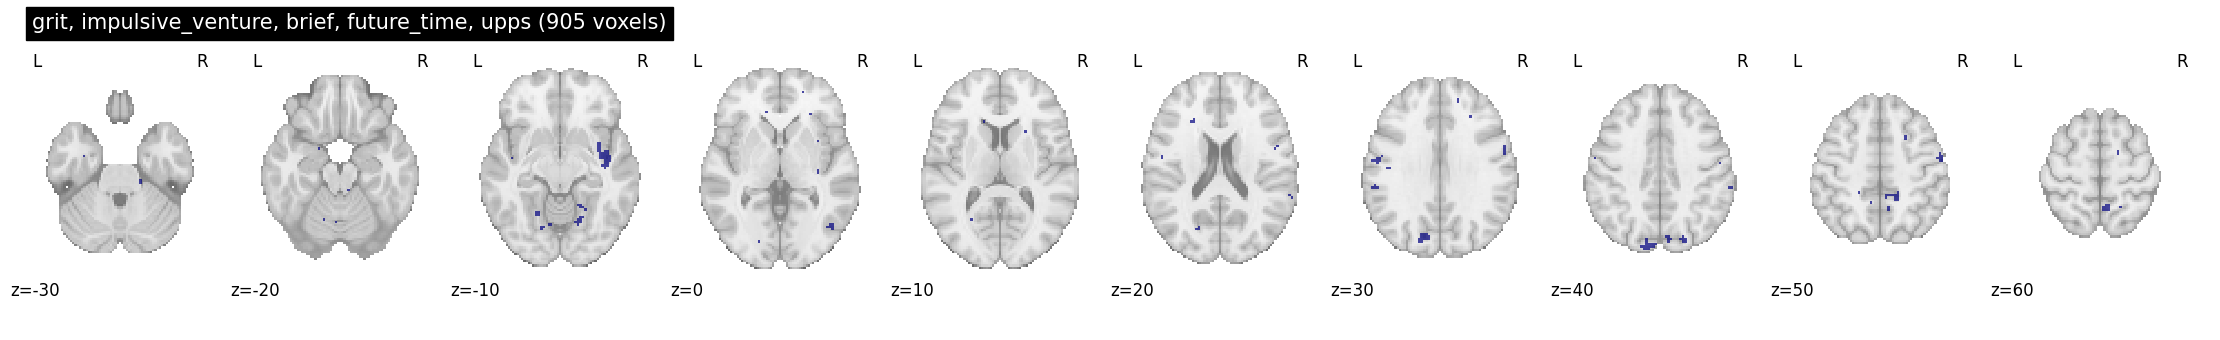

Integer 62: 899 voxels -> grit, impulsive_venture, future_time, brief, upps


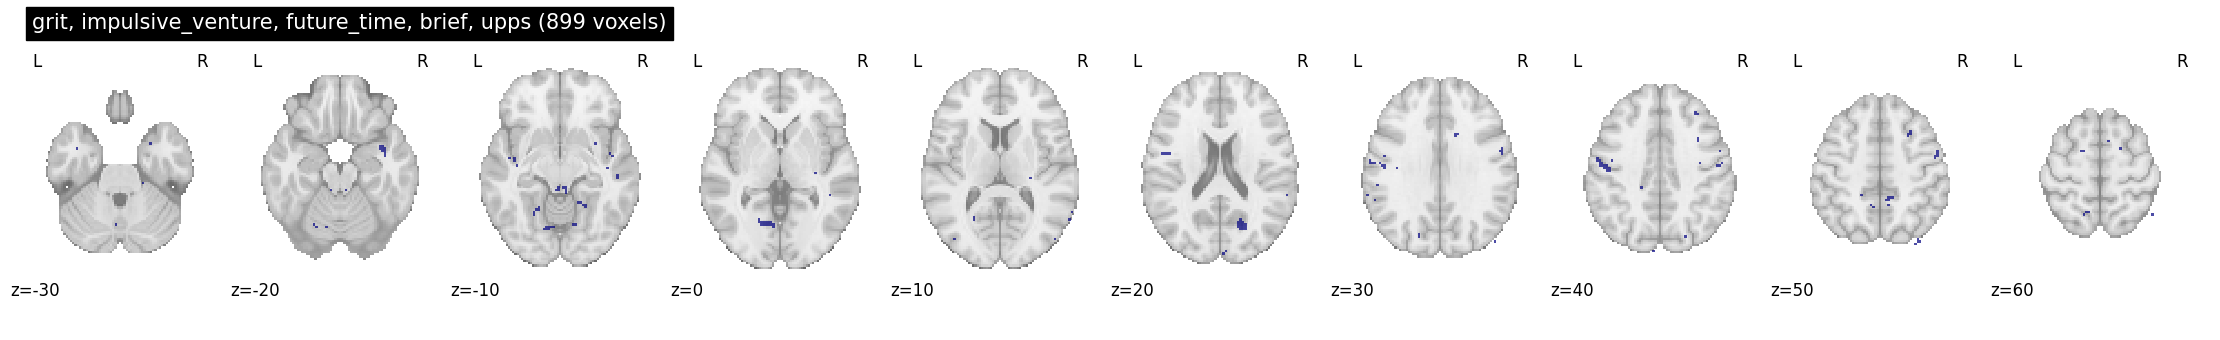

Integer 66: 1286 voxels -> grit, upps, brief, future_time, impulsive_venture


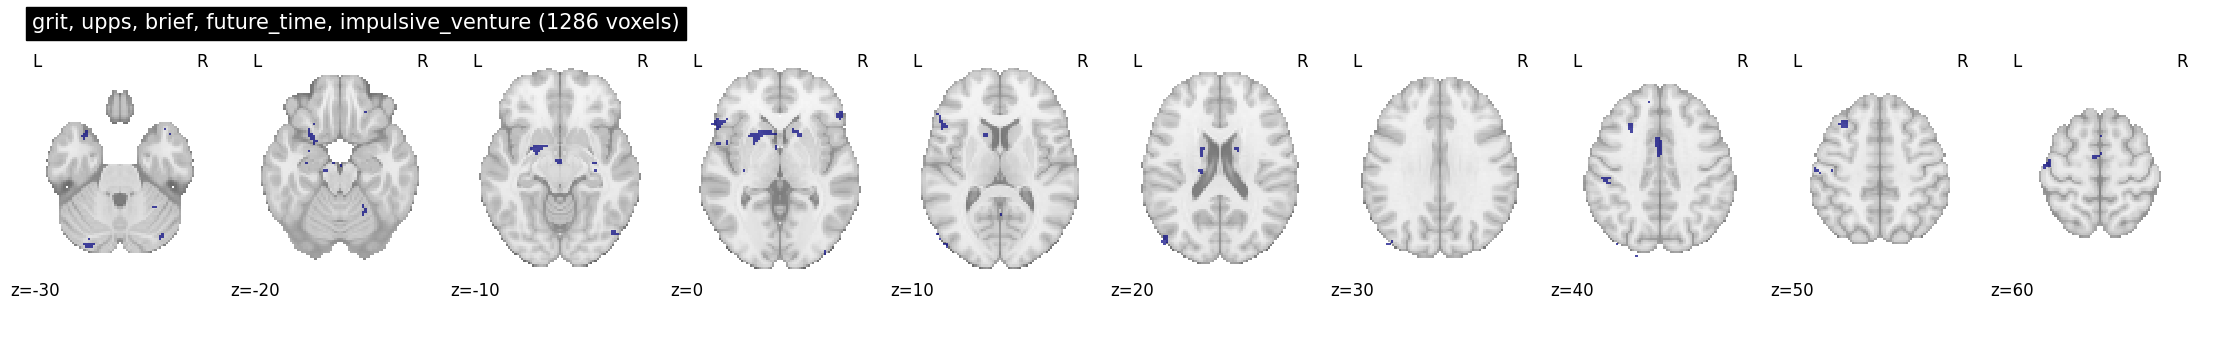

Integer 68: 1207 voxels -> grit, upps, future_time, brief, impulsive_venture


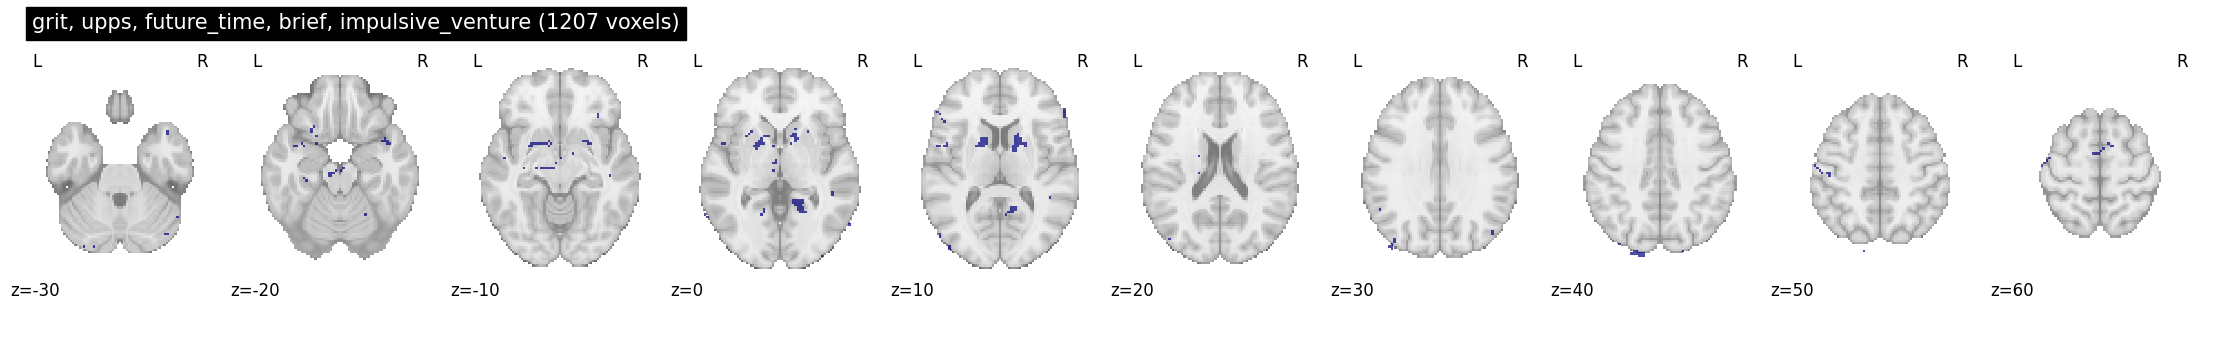

Integer 84: 1372 voxels -> impulsive_venture, grit, brief, future_time, upps


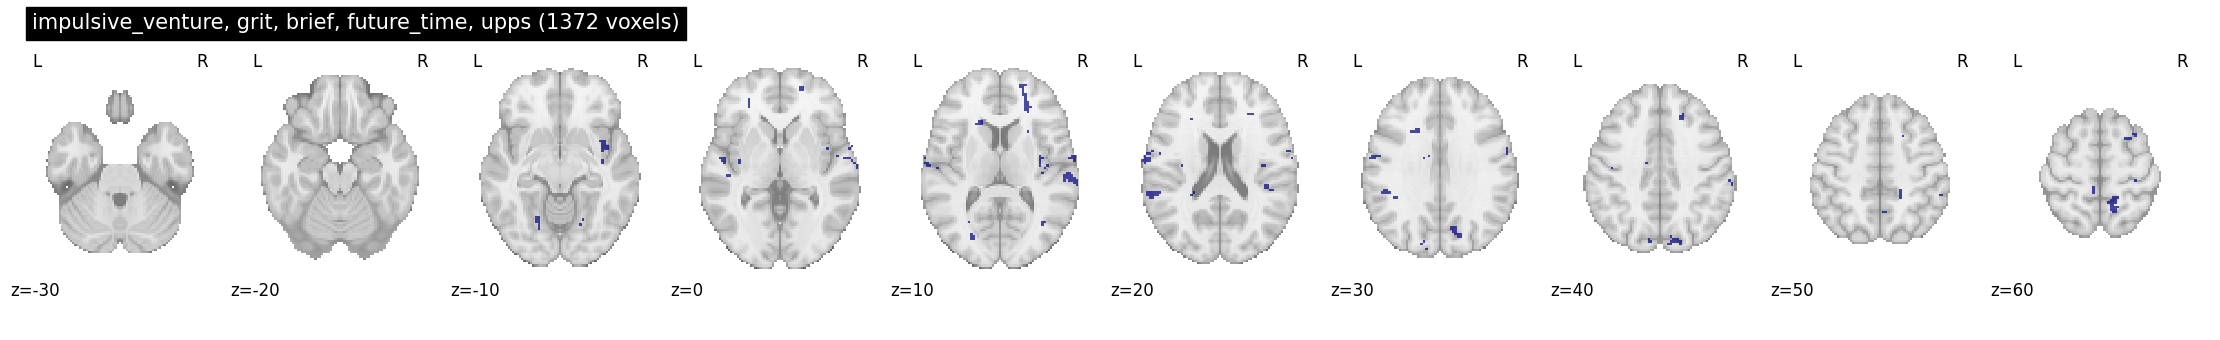

Integer 85: 1220 voxels -> impulsive_venture, grit, brief, upps, future_time


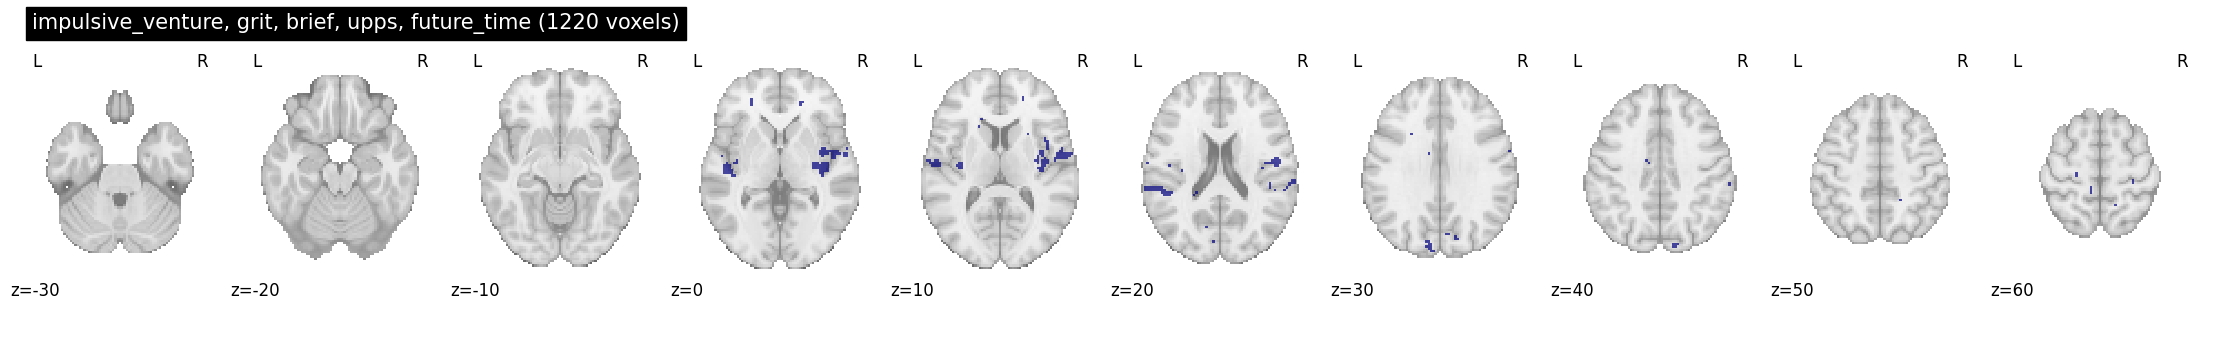

Integer 86: 986 voxels -> impulsive_venture, grit, future_time, brief, upps


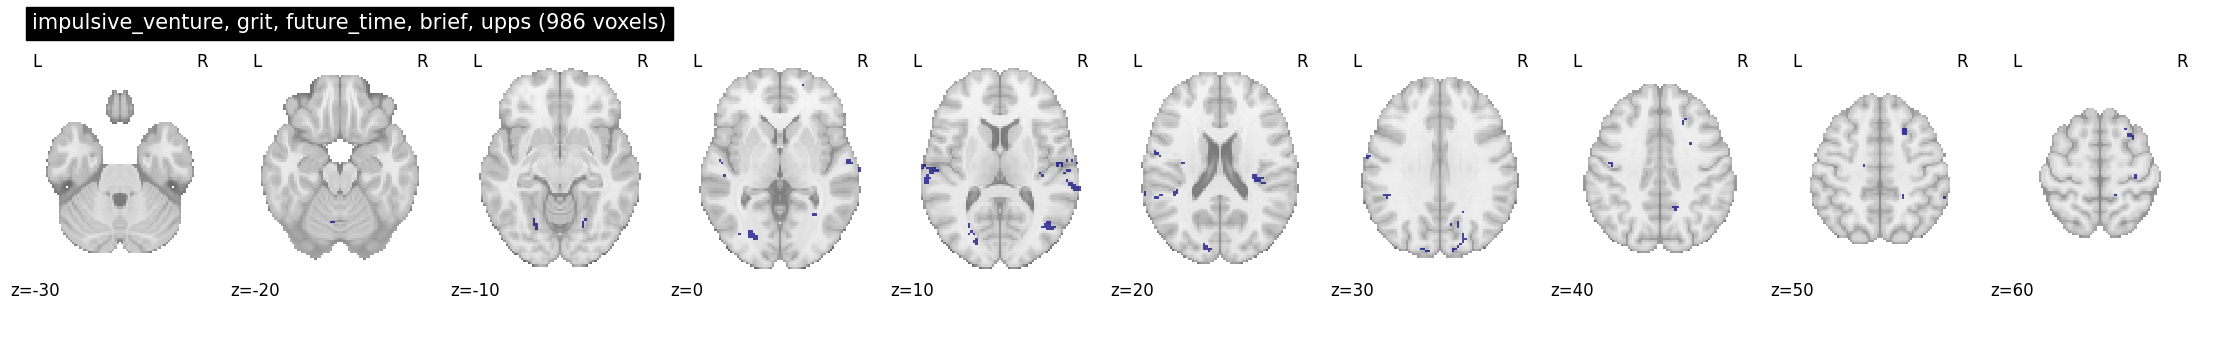

Integer 98: 2279 voxels -> upps, brief, grit, future_time, impulsive_venture


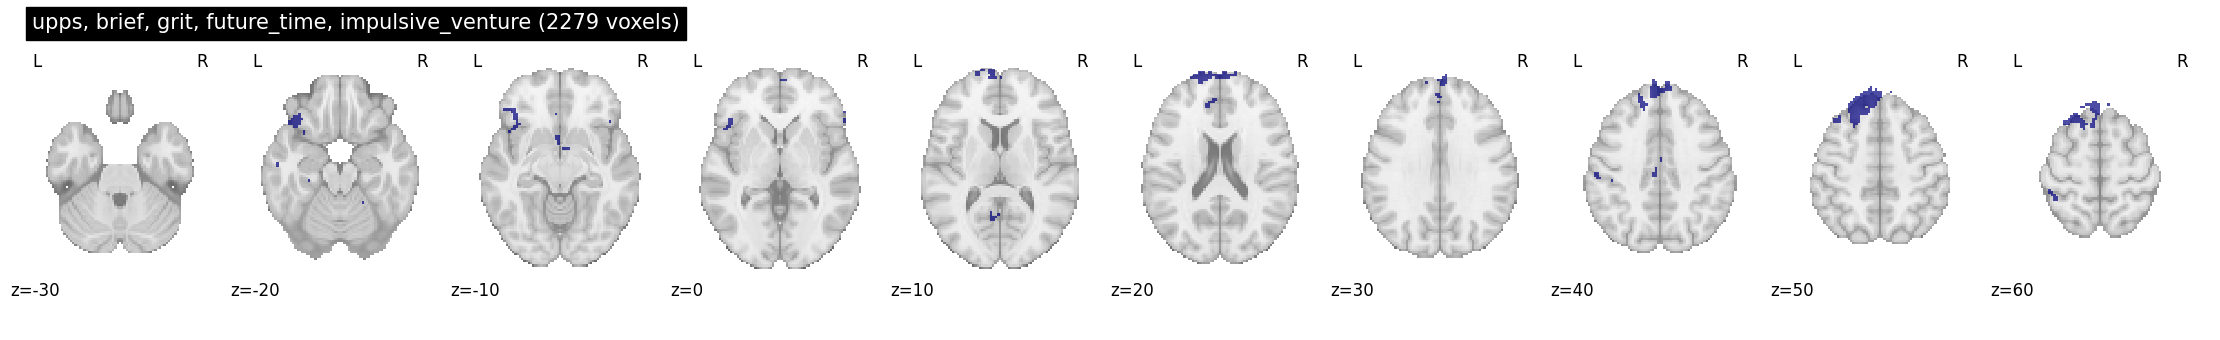

Integer 108: 1649 voxels -> upps, grit, brief, future_time, impulsive_venture


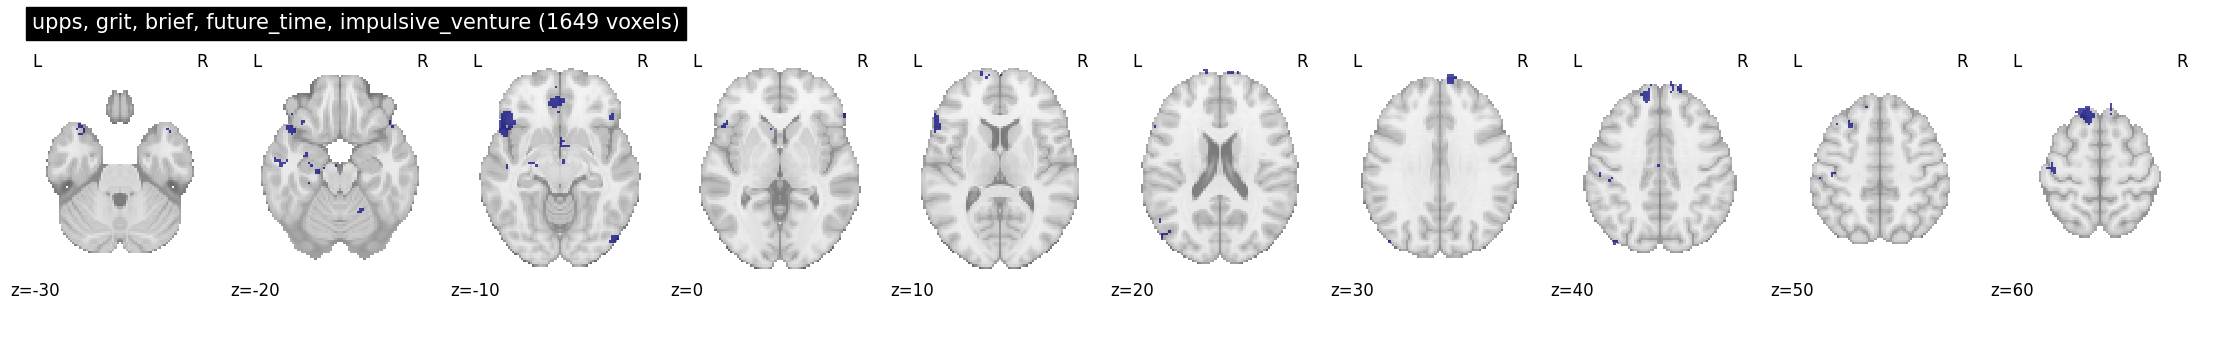

Integer 109: 1036 voxels -> upps, grit, brief, impulsive_venture, future_time


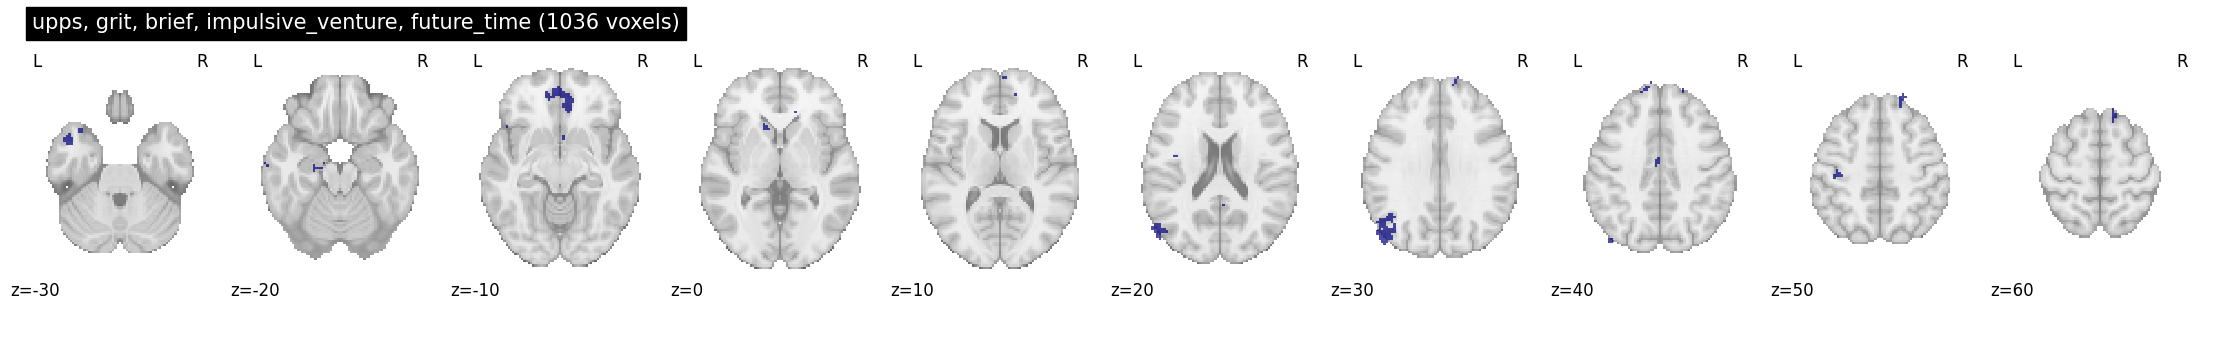

Integer 110: 1052 voxels -> upps, grit, future_time, brief, impulsive_venture


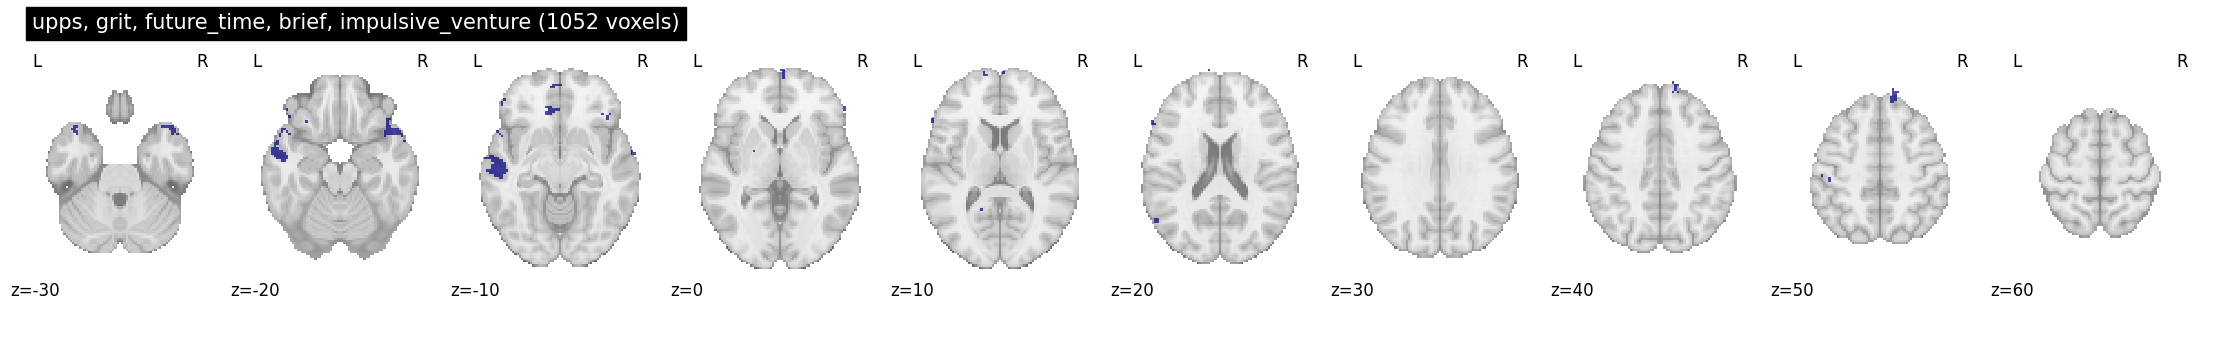

In [12]:
# Flatten data to count voxels per integer
masked_data = masked_rank_img.get_fdata().astype(int)
unique_vals, counts = np.unique(masked_data, return_counts=True)

# Loop over integers with more than 500 voxels
for val, n_vox in zip(unique_vals, counts):
    if val == 0 or n_vox <= 800:
        continue  # skip background or tiny clusters

    # Create binary mask for this rank
    binary_data = (masked_data == val).astype(np.int32)
    binary_img = new_img_like(masked_rank_img, binary_data)

    # Get text label for this rank
    ranking_perm = all_perms[val]  # tuple of indices
    ranking_labels = [questionnaires[i] for i in ranking_perm]
    label_text = ', '.join(ranking_labels)

    print(f'Integer {val}: {n_vox} voxels -> {label_text}')

    # Plot
    plot_roi(
        binary_img,
        display_mode='z',
        cut_coords=z_slices,
        title=f'{label_text} ({n_vox} voxels)',
        colorbar=False,
    )
    plt.show()